# Conditional Deep Convolutional Generative Adversarial Network

## Overview
이번 실습에서는 Conditional DCGAN을 구현하고, MNIST dataset을 이용하여 학습해보록 하겠습니다.  

지금까지 실습했던 Generative model들은, 특정 class에 대한 생성이 불가능한 model들이었습니다.
CGAN은 이미지 생성시에 Class condition을 활용하여, 특정 클래스의 이미지 생성이 가능합니다.

- 이 실습자료는 [GAN-Tutorial](https://github.com/Yangyangii/GAN-Tutorial)을 기반으로 작성되었습니다.

### Setup

우선, DCGAN 구현을 위해 필요한 패키지들을 설치하고 import하도록 하겠습니다.

In [1]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision import transforms
from torchvision.utils import save_image

import numpy as np
import datetime
import os, sys

from matplotlib.pyplot import imshow, imsave

DEVICE = torch.device('cuda')

### Load and prepare the dataset

이번 실습에서 사용할 MNIST dataset을 다운로드하고, 로드하겠습니다.

In [11]:
batch_size = 64

transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize(mean=[0.5],
                                std=[0.5])]
)

mnist = datasets.MNIST(root='./data/', train=True, transform=transform, download=True)
data_loader = DataLoader(dataset=mnist, batch_size=batch_size, shuffle=True, drop_last=True)

## CGAN 구현

지금부터 CGAN 모델을 구현하도록 하겠습니다.
이에 앞서 class condition 정보를 neural network가 받아들이기 편리하도록 0~1의 정수값에서 one hot vector로 만드는 코드를 준비하도록 하겠습니다.


In [2]:
def to_onehot(label, num_classes=10):
    assert isinstance(label, int) or isinstance(label, (torch.LongTensor, torch.cuda.LongTensor))
    if isinstance(label, int):
        c = torch.zeros(1, num_classes).long()
        c[0][label] = 1
    else:
        label = label.cpu()
        c = torch.LongTensor(label.size(0), num_classes)
        c.zero_()
        c.scatter_(1, label, 1) # dim, index, src value
    return c

### 1. Generator

- Generator input:
  - latent z: [batch, 100]
  - class y: [batch, 10] (one-hot vector)

- Generator output:
  - generated image G(z): [batch, 1, 28, 28]

- 기존 DCGAN과 대체로 유사하지만, input을 맞추어주는 layer가 추가로 필요합니다.
  * **Concat & FC**: (z, one-hot vector) [batch, 100+10] -> hidden feature [batch, 512x512x4]
    

In [3]:
class Generator(nn.Module):
    """
        Convolutional Generator for MNIST
    """
    def __init__(self, input_size=100, condition_size=10):
        super(Generator, self).__init__()
        ##################### ToDo #####################
        self.fc = nn.Sequential(
            # input: 100, output: 512x512x4
            nn.Linear(input_size + condition_size, 512 * 4 * 4),
            nn.BatchNorm1d(512 * 4 * 4),
            nn.ReLU(0.4)
        )
        self.conv = nn.Sequential(
            # input: 4 by 4, output: 7 by 7
            nn.ConvTranspose2d(512, 256, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            # input: 7 by 7, output: 14 by 14
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            # input: 14 by 14, output: 28 by 28
            nn.ConvTranspose2d(128, 1, kernel_size=4, stride=2, padding=1),
            nn.Tanh()
        )
        ##################################################

    def forward(self, z, y):
        # x: (N, 100), c: (N, 10)
        z, y = z.view(z.size(0), -1), y.float() # may not need
        x = torch.cat((z, y), 1) # v: (N, 110)
        x = self.fc(x)
        x = x.view(x.size(0), 512, 4, 4)
        x = self.conv(x) # (N, 28, 28)
        return x

In [4]:
G = Generator().to(DEVICE)

### 2. Discriminator

- Discriminator input:
  - real/fake image  x: [batch, 28, 28, 1]
  - class y: [batch, 10] (one-hot vector)

- Discriminator output:
  - real probability D(x): [batch, 10] with value range (0, 1)

- 기존 DCGAN의 discriminator와 달리, real/fake 이미지 외에 class contition y도 입력으로 받습니다. 이를 CNN에서 추가 정보로 활용하기 위해 이미지에 추가 채널로 concat하여 사용하게 됩니다.
이를 위해 class y [batch, 10]을 image shape으로 만들어주는 layer가 추가로 필요하게됩니다.
  1. **FC_y**: [batch, 10] → [batch, 28x28=784]
  2. **y reshape**: [batch, 28x28=784] → [batch, 1, 28, 28]
  3. **concat**: (x, y) [batch, 1+1, 28, 28]


In [5]:
class Discriminator(nn.Module):
    """
        Convolutional Discriminator for MNIST
    """
    def __init__(self, in_channel=1, input_size=784, condition_size=10, num_classes=1):
        super(Discriminator, self).__init__()

        ##################### ToDo #####################
        self.transform = nn.Sequential(
            # input: 10, output: 28x28 (label)
            nn.Linear(condition_size, 28 * 28),
        )
        self.conv = nn.Sequential(
            # 28 -> 14
            nn.Conv2d(in_channel+1, 512, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2),
            # 14 -> 7
            nn.Conv2d(512, 256, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),
            # 7 -> 4
            nn.Conv2d(256, 128, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
            nn.AvgPool2d(4)
        )
        self.fc = nn.Sequential(
            # input: 128x4x4, output: 1
            nn.Linear(128, 1),
            nn.Sigmoid()
        )
        ###################################################

    def forward(self, x, y=None):
        # x: (N, 1, 28, 28), c: (N, 10)
        x, y = x.float(), y.float() # may not need

        y = self.transform(y)
        y = y.view(y.size(0), 1, 28, 28)
        #y = y.reshape((-1, 1, 28, 28))
        h = torch.cat((x, y), 1) # v: (N, 2, 28, 28)

        h = self.conv(h)
        h = h.view(h.size(0), -1)
        h = self.fc(h)
        return h

In [6]:
D = Discriminator().to(DEVICE)

## Loss와 Optimizer 정의

모델 학습을 위해 loss와 optimizer를 선언해주도록 하겠습니다.

### Discriminator loss

아래 코드는 Discriminator를 위한 loss 구현 코드입니다.  
Discriminator의 학습 목표는, real image에 대해서는 1(or 높은 확률값)을 반환하고, fake image에 대해서는 0(or 낮은 확률값)을 반환하는 것입니다.

In [7]:
def discriminator_loss(real_output, fake_output):
    ################ ToDo ##################
    D_real_labels = torch.ones_like(real_output)
    D_fake_labels = torch.zeros_like(fake_output)

    real_loss = nn.BCELoss()(real_output, D_real_labels)
    fake_loss = nn.BCELoss()(fake_output, D_fake_labels)
    total_loss = real_loss + fake_loss
    ########################################
    return total_loss

### Generator loss
아래 코드는 Generator를 위한 loss 구현 코드입니다.  
Generator의 학습 목표는, discriminator를 속이는 것이며, 이는 fake output에 대해 1(or 높은 확률값)을 반환하도록 하는 것입니다.

In [13]:
def generator_loss(fake_output):
    ################ ToDo ##################
    G_fake_labels = torch.ones_like(fake_output)
    loss = nn.BCELoss()(fake_output, G_fake_labels)
    ########################################
    return loss

아래 코드는 각각의 model에 대한 optimizer를 선언해주는 코드입니다.

In [14]:
D_opt = torch.optim.Adam(D.parameters(), lr=0.0005, betas=(0.5, 0.999))
G_opt = torch.optim.Adam(G.parameters(), lr=0.0005, betas=(0.5, 0.999))

## Define the training loop

In [15]:
EPOCHS = 10
noise_dim = 100
num_examples_to_generate = 16
global_step = 0
n_critic = 1

아래 코드는 DCGAN 학습을 위한 train_step 코드입니다.  
1. 각 train_step마다 Generator는 **BATCH_SIZE**개 만큼의 이미지를 생성합니다.  
2. Discriminator는 Generator가 만든 **BATCH_SIZE**개의 이미지와, training set에서 가져온 **BATCH_SIZE**개의 이미지, 총 **2xBATCH_SIZE**개의 이미지에 대해 real/fake 판별을 진행합니다.
3. 이후 Generator, Discriminator에 대한 loss를 계산하고, Gradient를 계산한 뒤
4. Model의 Parameter를 업데이트해주게 됩니다.

In [16]:
G.train()
D.train()

G_train_loss_list = []
D_train_loss_list = []


for epoch in range(EPOCHS):
    for idx, (images, labels) in enumerate(data_loader):
        # Training Discriminator
        x = images.to(DEVICE)
        y = labels.view(labels.shape[0], 1)
        y_onehot = to_onehot(y).to(DEVICE)

        D_real_preds = D(x, y_onehot)

        z = torch.randn(batch_size, noise_dim).to(DEVICE)
        D_fake_preds = D(G(z, y_onehot), y_onehot)

        D_loss = discriminator_loss(D_real_preds, D_fake_preds)

        D.zero_grad()
        D_loss.backward()
        D_opt.step()

        if global_step % n_critic == 0:
            # Training Generator
            z = torch.randn(batch_size, noise_dim).to(DEVICE)
            D_fake_preds = D(G(z, y_onehot), y_onehot)
            G_loss = generator_loss(D_fake_preds)

            D.zero_grad()
            G.zero_grad()
            G_loss.backward()
            G_opt.step()

            G_train_loss_list.append(G_loss.data.item())
            D_train_loss_list.append(D_loss.data.item())

        if global_step % 500 == 0:
            print('Epoch: {}/{}, Step: {}, D Loss: {}, G Loss: {}'.format(epoch, EPOCHS, global_step, D_loss.item(), G_loss.item()))

        global_step += 1

Epoch: 0/10, Step: 0, D Loss: 1.3485275506973267, G Loss: 0.7366163730621338
Epoch: 0/10, Step: 500, D Loss: 0.9521074891090393, G Loss: 1.1071751117706299
Epoch: 1/10, Step: 1000, D Loss: 1.083208680152893, G Loss: 0.8524402976036072
Epoch: 1/10, Step: 1500, D Loss: 0.7797884941101074, G Loss: 1.1786222457885742
Epoch: 2/10, Step: 2000, D Loss: 0.6706844568252563, G Loss: 1.6982674598693848
Epoch: 2/10, Step: 2500, D Loss: 1.0489516258239746, G Loss: 1.5388128757476807
Epoch: 3/10, Step: 3000, D Loss: 0.776544451713562, G Loss: 1.5215641260147095
Epoch: 3/10, Step: 3500, D Loss: 0.9934582114219666, G Loss: 2.405978202819824
Epoch: 4/10, Step: 4000, D Loss: 0.7495909929275513, G Loss: 1.5904736518859863
Epoch: 4/10, Step: 4500, D Loss: 0.7250094413757324, G Loss: 1.1164381504058838
Epoch: 5/10, Step: 5000, D Loss: 0.8009614944458008, G Loss: 1.5820696353912354
Epoch: 5/10, Step: 5500, D Loss: 0.7551054954528809, G Loss: 1.4837329387664795
Epoch: 6/10, Step: 6000, D Loss: 0.642036795616

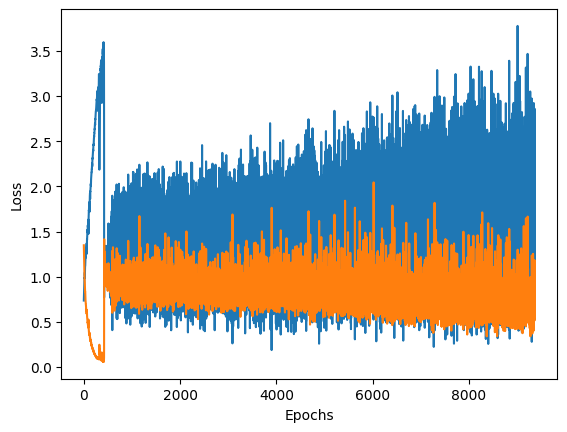

In [17]:
import matplotlib.pyplot as plt
plt.ion()

fig = plt.figure()
plt.plot(G_train_loss_list)
plt.plot(D_train_loss_list)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

### Generate and save images
아래 코드는 모델로부터 이미지를 생성하고 이를 확인하는 코드입니다.

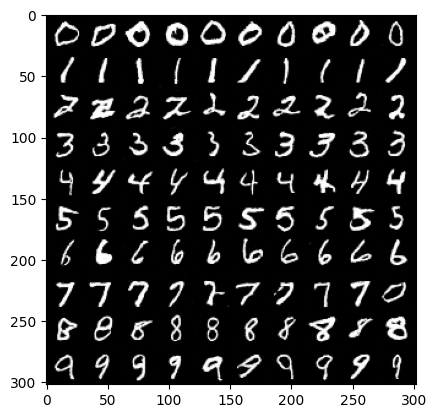

In [18]:
from torchvision.utils import make_grid

G.eval()

n_samples = 100

with torch.no_grad():
  z = torch.randn(n_samples, 100).to(DEVICE)
  y = torch.arange(10).view(10, 1).repeat(1, 10).view(100, 1)
  y_onehot = to_onehot(y).to(DEVICE)
  x_hat = G(z, y_onehot)

img = make_grid(x_hat, nrow=10, normalize=True, value_range=(-1., 1.)).permute(1, 2, 0).cpu().data.numpy()

imshow(img, cmap='gray')